# Linear Regression Project

This project is an attempt to predict the price of a used car using a Linear Regression Model

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## 1. Get Data

In [2]:
raw_data = pd.read_csv('cardata.csv')

In [3]:
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## 2. Exploratory Data Analysis

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


In [5]:
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Here we can see from <b>count</b> that there is definitely missing data, we can also see how many unique instances there are for each column. Model for instance has 312 unique instances which will make it difficult to transform into dummy varaibles.

<AxesSubplot:xlabel='Price', ylabel='Count'>

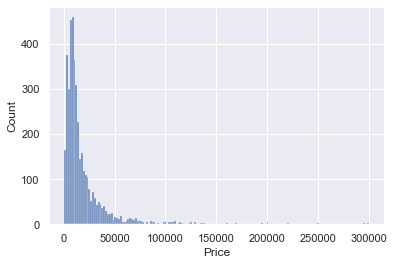

In [6]:
sns.histplot(raw_data['Price'])

Upon evaluation of the field we are trying to predict we can see that there are definitely outliers resulting in a positively skewed distribution

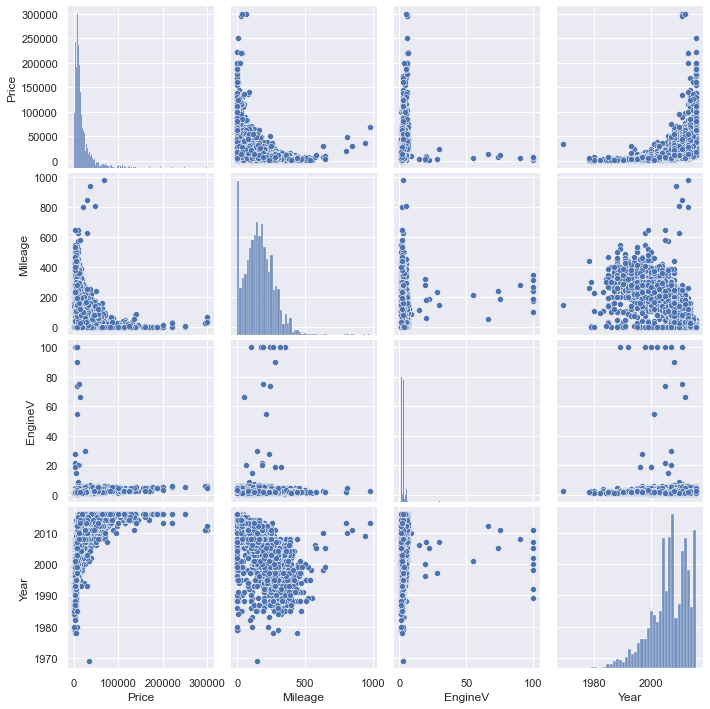

In [7]:
sns.pairplot(raw_data)

The pairplot shows us that there are a few exponential distributions and that not only Price but Mileage, EngineV and Year all contain outliers which ar skewing their distributions.

## 3. Preprocessing

### 3.1 - Unnecessary Variables

Because of the large amount of unique instances incorporating the Model varaible in our regression might be unnecessarily difficult

In [8]:
raw_data.drop('Model',axis=1, inplace=True)

### 3.2 - Missing Data

In [9]:
raw_data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

We can see that there are 172 Prices missing and 150 EngineV missing, this can also be visualized:

<AxesSubplot:>

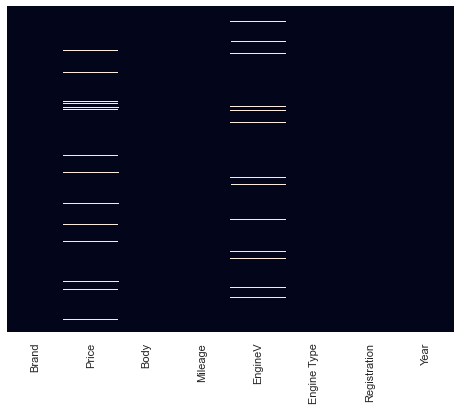

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(raw_data.isnull(), yticklabels= False, cbar= False)

Here the light strips indicate missing values. To fill in the missing values for Price we are going to take the average price of cars of that Brand for that year.

In [11]:
def impute_price(cols):
    price = cols[0]
    brand = cols[1]
    year = cols[2]
    
    if pd.isnull(price):
        return raw_data[(raw_data['Brand'] == brand) & (raw_data['Year']== year)]['Price'].mean()
    else:
        return price

In [12]:
raw_data['Price'] = raw_data[['Price', 'Brand', 'Year']].apply(impute_price, axis =1 )

In [13]:
raw_data.isnull().sum()

Brand             0
Price             0
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

We can use a similar process to replace the missing Engine V values with the average Engine V value of cars of a specific Brand and Body Type

In [14]:
def impute_engine(cols):
    engV = cols[0]
    brand = cols[1]
    body = cols[2]
    
    if pd.isnull(engV):
        return raw_data[(raw_data['Brand']==brand) & (raw_data['Body']==body)]['EngineV'].mean()
    else:
        return engV

In [15]:
raw_data['EngineV'] = raw_data[['EngineV','Brand','Body']].apply(impute_engine, axis = 1)

In [16]:
raw_data.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

In [19]:
data_no_mv = raw_data

### 3.3 - Outliers

#### 3.3.1 - Price Outliers

<AxesSubplot:xlabel='Price', ylabel='Count'>

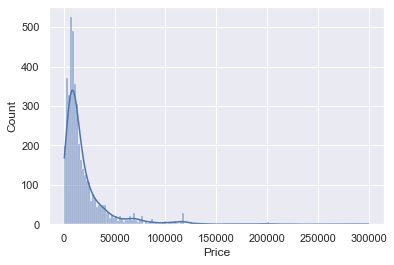

In [22]:
sns.histplot(data_no_mv['Price'], kde = True)

As we saw earlier price's positive skew is the result of outliers which can be eliminated. In this instance removing the top 1% of prices could help rectify the skew.

In [23]:
quant_1 = data_no_mv['Price'].quantile(0.99)

In [25]:
data_no_ol1 = data_no_mv[data_no_mv['Price']<quant_1]

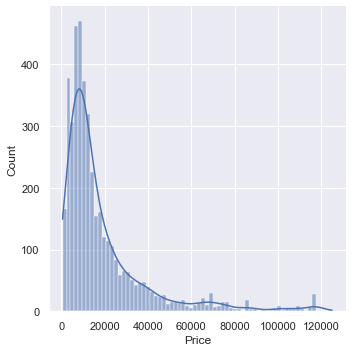

In [26]:
sns.displot(data_no_ol1['Price'], kde = True)

We can see that removing these outliers has helped reduce the skew of the graph

#### 3.3.2 - Mileage Outliers

We can repeat a similar process for mileage which we can see is also being effected by outliers

<AxesSubplot:xlabel='Mileage', ylabel='Count'>

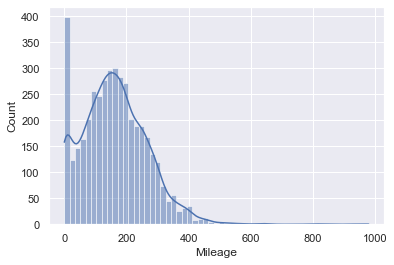

In [27]:
sns.histplot(data_no_ol1['Mileage'], kde = True)

In [28]:
quant_2 = data_no_ol1['Mileage'].quantile(0.99)

In [29]:
data_no_ol2 = data_no_ol1[data_no_ol1['Mileage']<quant_2]

<AxesSubplot:xlabel='Mileage', ylabel='Count'>

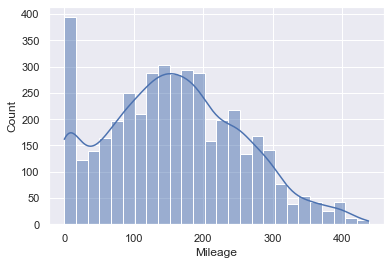

In [30]:
sns.histplot(data_no_ol2['Mileage'], kde = True)

#### 3.3.3- Year Outliers

<AxesSubplot:xlabel='Year', ylabel='Count'>

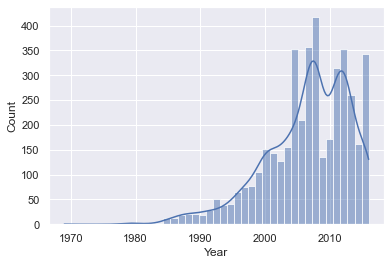

In [31]:
sns.histplot(data_no_ol2['Year'], kde=True)

Here we see a slightly different scenario in which the data is negatively skewed, accounting for these outliers will involve removing the lowest 1% of values.

In [32]:
quant_3 = data_no_ol2['Year'].quantile(0.01)

In [33]:
data_no_ol3 = data_no_ol2[data_no_ol2['Year']>quant_3]

<AxesSubplot:xlabel='Year', ylabel='Count'>

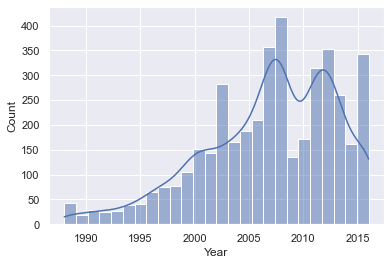

In [34]:
sns.histplot(data_no_ol3['Year'], kde=True)

In [35]:
data_no_ol = data_no_ol3

### 3.4 - Erroneous Values

<AxesSubplot:xlabel='EngineV', ylabel='Count'>

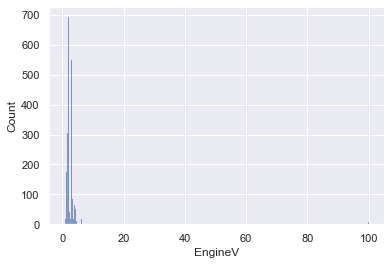

In [37]:
sns.histplot(data_no_ol['EngineV'])

Here we can see the data is extremely skewed, this could be due to an outlier or because of erraneous values.

In [38]:
data_no_ol['EngineV'].describe()

count    4196.000000
mean        2.781930
std         5.060262
min         0.600000
25%         1.900000
50%         2.200000
75%         3.000000
max        99.990000
Name: EngineV, dtype: float64

Looking at this information we can clearly see that the max of 99.99 is much higher than the average of 2.7 this is because old data storage software would store 99 as the default value. Some research into engine values indicates the value should never be more than 6

In [39]:
data_no_er  = data_no_ol[data_no_ol['EngineV']< 6]

In [40]:
data_no_er['EngineV'].describe() 

count    4143.000000
mean        2.447154
std         0.895553
min         0.600000
25%         1.811765
50%         2.200000
75%         3.000000
max         5.700000
Name: EngineV, dtype: float64

<AxesSubplot:xlabel='EngineV', ylabel='Count'>

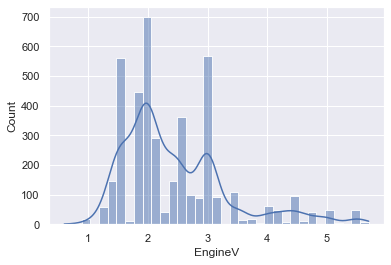

In [41]:
sns.histplot(data_no_er['EngineV'], kde=True)

### 3.5 - Check Linearity 

With the outliers removed the next step is to check for linearity as it is an assumption we neeed to use the Linear Regression. As we can see the <b> Mileage, Year and Engine V </b> are more or less normally distributed whilst price is exponentially dsitributed. To fix this we can use the <b> Log Transformation </b>.

<AxesSubplot:xlabel='Price', ylabel='Count'>

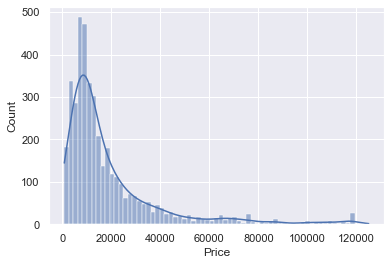

In [42]:
sns.histplot( data_no_er['Price'], kde = True)

<AxesSubplot:xlabel='Price', ylabel='Count'>

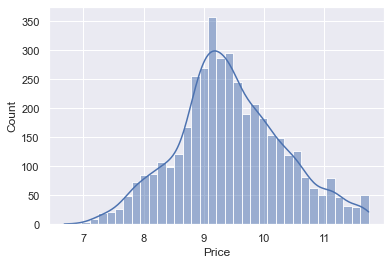

In [43]:
log_price = np.log(data_no_er['Price'])
sns.histplot(log_price, kde = True)

This results in a far more normal distribution for price but also results in more linear relationships between price and Year, Mileage and EngineV.

In [45]:
data_no_er['Log Price'] = log_price

<ipython-input-45-807ba4cb689c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_er['Log Price'] = log_price


In [46]:
data_linear = data_no_er
data_linear.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Log Price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656


<AxesSubplot:xlabel='Log Price', ylabel='Year'>

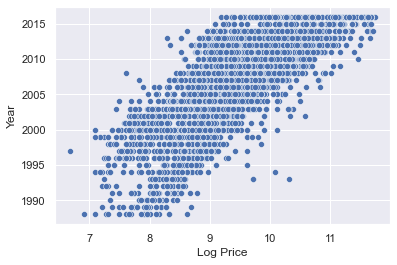

In [47]:
sns.scatterplot(x='Log Price', y = 'Year' , data = data_linear)

Notice how it now represents a more linear distribution which allows us to use th linear regression

### 3.6 - Make sure there is no Multicollinearity 

Multicollinearity occurs when one or more varaibles that are being used in the model can be derived from other variables. In other words one, or more, of the numerical variables are redundant. To check for multicollinearity we use the <b>Varaince Inflation Factor.</b> imported from <b>Stats Models</b>

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [49]:
variables = data_linear[['Mileage','Year','EngineV']]

In [50]:
vif = pd.DataFrame()
vif['Features'] = variables.columns
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif

,Features,VIF
0,Mileage,3.634092
1,Year,11.101280
2,EngineV,8.467143


A VIF of 1 means there is no multicollinearity. Anything under 6-10 is okay but 10 is the maximum. A VIF of 11 means that the year can be derived from the Mileage and EngineV and does not necessarily need to be included as well

In [51]:
data_linear.drop('Year', axis =1 )

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Log Price
0,BMW,4200.0,sedan,277,2.000000,Petrol,yes,8.342840
1,Mercedes-Benz,7900.0,van,427,2.900000,Diesel,yes,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.000000,Gas,yes,9.495519
3,Audi,23000.0,crossover,240,4.200000,Petrol,yes,10.043249
4,Toyota,18300.0,crossover,120,2.000000,Petrol,yes,9.814656
...,...,...,...,...,...,...,...,...
4338,Volkswagen,11500.0,van,163,2.500000,Diesel,yes,9.350102
4339,Toyota,17900.0,sedan,35,1.600000,Petrol,yes,9.792556
4341,BMW,6500.0,sedan,1,3.500000,Petrol,yes,8.779557
4343,Toyota,14200.0,sedan,31,2.379948,Petrol,yes,9.560997


### 3.7 - Scale Numerical Input Information

In [52]:
data_num = data_linear[['Mileage','EngineV']]

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
scaler = StandardScaler()

In [55]:
scaler.fit(X=data_num)

StandardScaler()

In [56]:
data_num_scaled = scaler.transform(data_num)
data_num_scaled_df = pd.DataFrame(data_num_scaled, columns=['Mileage','EngineV'])
data_num_scaled_df.head()

,Mileage,EngineV
0,1.225376,-0.499365
1,2.772237,0.505722
2,2.060681,2.850924
3,0.843817,1.957513
4,-0.393671,-0.499365


### 3.8  - Create Dummies for Categorical Input Information

The dummy varaibles will be the numerical represenation of categorical information when we feed it into the model

In [57]:
data_linear.columns

Index(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Log Price'],
      dtype='object')

In [58]:
data_cat = data_linear[['Brand', 'Body', 'Engine Type', 'Registration']]

In [59]:
data_cat_dummies = pd.get_dummies(data_cat, drop_first= True)

It is very important to note here that the <b>drop_first</b> method is used because if a varaibles has N possibilities you only need N-1 dummies for it as the last one can be determined by the others. Leaving it in would result in multicollinearity.

In [60]:
data_cat_dummies.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


## 4. Create the model

With all the preprocessing done we can now move on to creating the model.

### 4.1 - Set up input variables and target

In [61]:
X = pd.concat([data_num, data_cat_dummies], axis = 1)

In [62]:
X.head()

,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [63]:
y = data_linear['Log Price']

In [64]:
y.head()

0     8.342840
1     8.974618
2     9.495519
3    10.043249
4     9.814656
Name: Log Price, dtype: float64

### 4.2 - Split into Training and Test Data

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.3 - Create Model

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
linear_reg = LinearRegression()

In [69]:
linear_reg.fit(X_train,y_train)

LinearRegression()

## 5 - Evaluate Model 

### 5.1 - Calculate R Squared Value

In [70]:
linear_reg.score(X_test,y_test)

0.7459322700701485

This means the values we are using explain roughly 75% of the varaibility in the data

### 5.2 - Check Predictions

In [71]:
y_pred = linear_reg.predict(X_test)

<AxesSubplot:xlabel='Log Price'>

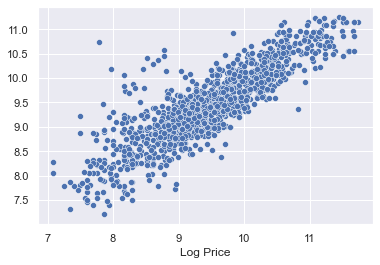

In [72]:
sns.scatterplot(x = y_test , y = y_pred )

Having this linear relationship indicates that our model is doing pretty well, we can also see that as the price gets more expensive our model gets a bit better at explaining as the points are closer together.

### 5.3 - Compare results

In [73]:
res_summary = pd.DataFrame()

In [74]:
res_summary['Target Price'] = np.exp(y_test)

In [75]:
res_summary['Predicted Price'] = np.exp(y_pred)

In [76]:
res_summary['Percent Difference'] = (abs(res_summary['Target Price']-res_summary['Predicted Price'])/res_summary['Target Price'])*100

In [77]:
res_summary.sort_values(by='Percent Difference', ascending=False).head(999)

,Target Price,Predicted Price,Percent Difference
2779,2400.0,45919.564772,1813.315199
30,2900.0,26642.642733,818.711818
3028,3500.0,23246.691902,564.191197
225,4999.0,32929.062007,558.712983
4341,6500.0,38854.147955,497.756122
...,...,...,...
3835,12000.0,10898.596673,9.178361
590,17200.0,15623.963253,9.163004
786,13900.0,15167.936062,9.121842
3052,18900.0,20613.851397,9.067997
